In [ ]:
# If you're running this in Colab or fresh Python, uncomment below:
!pip install torch torch_geometric networkx matplotlib scikit-learn

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt

In [ ]:
NUM_NODES = 1000
IC_P = 0.05
MAX_STEPS = 15
SENTINEL = MAX_STEPS + 1

def simulate_ic(G, seeds, p=IC_P, max_steps=MAX_STEPS):
    infected = set(seeds)
    new_infected = set(seeds)
    cascade = [set(seeds)]

    for _ in range(max_steps):
        next_infected = set()
        for node in new_infected:
            for neighbor in G.neighbors(node):
                if neighbor not in infected and random.random() < p:
                    next_infected.add(neighbor)
        if not next_infected:
            break
        infected |= next_infected
        cascade.append(next_infected)
        new_infected = next_infected
    return cascade

In [ ]:
def mask_infections(x, sentinel=SENTINEL, mask_rate=0.2):
    x_masked = x.clone()
    mask = torch.rand_like(x_masked) < mask_rate
    x_masked[mask] = sentinel
    return x_masked

In [ ]:
def cascade_to_node_features(G, cascade, sentinel=SENTINEL):
    infection_time = {node: sentinel for node in G.nodes()}
    for t, nodes in enumerate(cascade):
        for n in nodes:
            if infection_time[n] == sentinel:
                infection_time[n] = t
    return torch.tensor([infection_time[n] for n in G.nodes()], dtype=torch.float).unsqueeze(1)

In [ ]:
def generate_batch_on_graph_with_pe(G, edge_index, pe, batch_size, mask_rate=0.2):
    data_list = []
    for _ in range(batch_size):
        source = random.choice(list(G.nodes()))
        cascade = simulate_ic(G, [source])
        x = cascade_to_node_features(G, cascade)  # [N, 1]
        x = mask_infections(x, sentinel=SENTINEL, mask_rate=mask_rate)
        data = Data(x=x, edge_index=edge_index, pe=pe, y=source)
        data_list.append(data)
    return data_list

In [ ]:
from torch_geometric.nn import GATConv, BatchNorm
import torch
import torch.nn as nn
import torch.nn.functional as F

class GATPE_SGNN(nn.Module):
    def __init__(self, in_channels=1, pe_dim=16, hidden_dim=256, num_layers=4, dropout=0.3, num_nodes=1000, heads=4):
        super().__init__()
        self.num_nodes = num_nodes
        self.num_layers = num_layers
        self.dropout = dropout
        self.hidden_dim = hidden_dim
        self.in_channels = in_channels + pe_dim

        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()

        # First GAT layer
        self.convs.append(GATConv(self.in_channels, hidden_dim // heads, heads=heads, concat=True))
        self.norms.append(BatchNorm(hidden_dim))

        # Hidden GAT layers
        for _ in range(num_layers - 1):
            self.convs.append(GATConv(hidden_dim, hidden_dim // heads, heads=heads, concat=True))
            self.norms.append(BatchNorm(hidden_dim))

        self.out = nn.Linear(hidden_dim, 1)

    def forward(self, x, pe, edge_index, batch):
        x = torch.cat([x, pe], dim=1)  # Append Laplacian PE

        for i in range(self.num_layers):
            x_res = x
            x = self.convs[i](x, edge_index)
            x = self.norms[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if x.shape == x_res.shape:
                x = x + x_res  # skip connection

        x = self.out(x).squeeze(-1)  # shape: [B*N]
        return x.view(-1, self.num_nodes)  # shape: [B, N]

In [ ]:
from torch_geometric.utils import get_laplacian

def compute_laplacian_pe(edge_index, num_nodes, pe_dim=16):
    lap_edge_index, lap_edge_weight = get_laplacian(edge_index, normalization='sym')
    L = torch.sparse_coo_tensor(lap_edge_index, lap_edge_weight, (num_nodes, num_nodes)).to_dense()
    eigvals, eigvecs = torch.linalg.eigh(L.cpu())
    return eigvecs[:, 1:pe_dim+1]  # exclude trivial eigenvector

In [ ]:
def train_batch_epoch(model, G, edge_index, pe, optimizer, criterion, device,
                      batch_size=16, steps_per_epoch=64, accum_steps=4):
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for i in tqdm(range(steps_per_epoch)):
        batch_data = generate_batch_on_graph_with_pe(G, edge_index, pe, batch_size)
        batch = Batch.from_data_list(batch_data).to(device)

        logits = model(batch.x, batch.pe, batch.edge_index, batch.batch)  # [B, N]
        labels = torch.tensor([d.y for d in batch_data], dtype=torch.long).to(device)  # [B]
        loss = criterion(logits, labels) / accum_steps  # scale for gradient accumulation
        loss.backward()

        if (i + 1) % accum_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item() * accum_steps  # undo scaling for tracking

    # Final step if total steps % accum_steps ≠ 0
    if steps_per_epoch % accum_steps != 0:
        optimizer.step()
        optimizer.zero_grad()

    return total_loss / steps_per_epoch


@torch.no_grad()
def evaluate_batched(model, G, edge_index, pe, device, batch_size=512, num_batches=3):
    model.eval()
    correct = 0
    total = 0

    for _ in range(num_batches):
        batch_data = generate_batch_on_graph_with_pe(G, edge_index, pe, batch_size)
        batch = Batch.from_data_list(batch_data).to(device)
        logits = model(batch.x, batch.pe, batch.edge_index, batch.batch)
        preds = logits.argmax(dim=1)
        labels = torch.tensor([d.y for d in batch_data], dtype=torch.long).to(device)
        correct += (preds == labels).sum().item()
        total += batch_size

    return correct / total

In [18]:
from tqdm import tqdm
from torch_geometric.data import Batch


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Compute fixed graph, edge_index, and Laplacian PE
G = nx.barabasi_albert_graph(NUM_NODES, 5)
edge_index = torch.tensor(list(G.edges()), dtype=torch.long).t().contiguous()
pe = compute_laplacian_pe(edge_index, num_nodes=NUM_NODES, pe_dim=16).float()

# Instantiate model with appropriate input dim (infection time + PE)
model = GATPE_SGNN(
    in_channels=1,
    pe_dim=16,
    hidden_dim=256,
    num_layers=4,
    dropout=0.3,
    num_nodes=NUM_NODES,
    heads=4
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train
for epoch in range(1, 13):
    loss = train_batch_epoch(model, G, edge_index, pe, optimizer, criterion, device,
                             batch_size=192, steps_per_epoch=400)
    acc = evaluate_batched(model, G, edge_index, pe, device)
    print(f"Epoch {epoch:02d} | Loss: {loss:.4f} | Accuracy: {acc:.4f}")

100%|██████████| 400/400 [03:42<00:00,  1.80it/s]


Epoch 01 | Loss: 2.1826 | Accuracy: 0.7884


100%|██████████| 400/400 [03:42<00:00,  1.80it/s]


Epoch 02 | Loss: 1.4172 | Accuracy: 0.8092


100%|██████████| 400/400 [03:42<00:00,  1.80it/s]


Epoch 03 | Loss: 1.3510 | Accuracy: 0.8027


100%|██████████| 400/400 [03:42<00:00,  1.80it/s]


Epoch 04 | Loss: 1.3227 | Accuracy: 0.7917


100%|██████████| 400/400 [03:42<00:00,  1.80it/s]


Epoch 05 | Loss: 1.3109 | Accuracy: 0.8040


100%|██████████| 400/400 [03:42<00:00,  1.80it/s]


Epoch 06 | Loss: 1.2909 | Accuracy: 0.8125


100%|██████████| 400/400 [03:42<00:00,  1.80it/s]


Epoch 07 | Loss: 1.3058 | Accuracy: 0.7904


  6%|▋         | 25/400 [00:14<03:36,  1.73it/s]


KeyboardInterrupt: 

In [39]:
@torch.no_grad()
def evaluate_batched_topk(model, G, edge_index, pe, device, batch_size=192, num_batches=10, k_values=[1, 3, 5, 10, 20, 50, 100]):
    model.eval()
    results = {k: 0 for k in k_values}
    total = 0

    for _ in range(num_batches):
        batch_data = generate_batch_on_graph_with_pe(G, edge_index, pe, batch_size)
        batch = Batch.from_data_list(batch_data).to(device)

        logits = model(batch.x, batch.pe, batch.edge_index, batch.batch)  # [B, N]
        sorted_preds = logits.argsort(dim=1, descending=True)  # [B, N]
        labels = torch.tensor([d.y for d in batch_data], dtype=torch.long).to(device)  # [B]

        for k in k_values:
            topk = sorted_preds[:, :k]
            match = (topk == labels.unsqueeze(1)).any(dim=1)
            results[k] += match.sum().item()

        total += batch_size

    for k in k_values:
        results[k] /= total

    return results

In [40]:
res_top_k = evaluate_batched_topk(model, G, edge_index, pe, device)
for k, acc in res_top_k.items():
    print(f"Top-{k} Accuracy: {acc:.4f}")

Top-1 Accuracy: 0.8255
Top-3 Accuracy: 0.8333
Top-5 Accuracy: 0.8380
Top-10 Accuracy: 0.8453
Top-20 Accuracy: 0.8490
Top-50 Accuracy: 0.8562
Top-100 Accuracy: 0.8656


In [41]:
import matplotlib.pyplot as plt

def plot_top_k_accuracy(acc_dict):
    ks = sorted(acc_dict.keys())
    accs = [acc_dict[k] for k in ks]

    plt.figure(figsize=(4, 3))
    plt.plot(ks, accs, marker='o', linewidth=2)
    plt.xticks(ks)
    plt.ylim(0, 1.05)
    plt.xlabel("k")
    plt.ylabel("Top‑k Accuracy")
    plt.title("(a) Top‑k Accuracy of SGNN Source Prediction")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

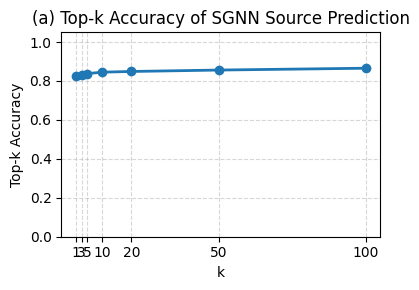

In [42]:
plot_top_k_accuracy(res_top_k)

In [43]:
print(res_top_k)

{1: 0.8255208333333334, 3: 0.8333333333333334, 5: 0.8380208333333333, 10: 0.8453125, 20: 0.8489583333333334, 50: 0.85625, 100: 0.865625}


In [44]:
@torch.no_grad()
def get_large_cascade_probs(model, G, device, min_infected=50):
    while True:
        source = random.choice(list(G.nodes()))
        cascade = simulate_ic(G, [source])
        infected = set().union(*cascade)
        if len(infected) >= min_infected:
            break

    x = cascade_to_node_features(G, cascade)
    edge_index = torch.tensor(list(G.edges()), dtype=torch.long).t().contiguous()

    x = x.to(device)
    edge_index = edge_index.to(device)
    batch = torch.zeros(x.size(0), dtype=torch.long).to(device)

    logits = model(x, edge_index, batch)
    probs = F.softmax(logits, dim=1).squeeze(0).cpu().numpy()

    return probs, source, cascade

In [ ]:
def plot_source_prob_heatmap_clean(G, probs, true_source, pred_source, cascade, threshold=0.01, cmap='Oranges'):
    infected_nodes = set()
    for timestep in cascade:
        infected_nodes.update(timestep)

    subgraph = G.subgraph(infected_nodes)
    pos = nx.kamada_kawai_layout(subgraph)

    fig, ax = plt.subplots(figsize=(5, 5))
    node_color = [probs[n] for n in subgraph.nodes()]
    node_size = [200 + 3000 * probs[n] for n in subgraph.nodes()]  # bump min size

    border_colors = []
    for n in subgraph.nodes():
        if n == true_source:
            border_colors.append('green')
        elif n == pred_source:
            border_colors.append('black')
        else:
            border_colors.append('#444444')  # gray border for all

    nodes = nx.draw_networkx_nodes(
        subgraph, pos,
        node_color=node_color,
        cmap=cmap,
        node_size=node_size,
        edgecolors=border_colors,
        linewidths=1.5,
        ax=ax
    )
    nx.draw_networkx_edges(subgraph, pos, alpha=0.3, width=0.5, ax=ax)

    ax.set_title("(b) SGNN Predicted Source Probabilities (Single Cascade)", fontsize=10)
    ax.axis('off')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max(node_color)))
    sm.set_array([])
    fig.colorbar(sm, ax=ax, shrink=0.75, label='Predicted Source Probability')

    # Annotations
    ax.annotate("True Source", pos[true_source], xytext=(-10, 10),
                textcoords='offset points', color='green', fontsize=8, fontweight='bold')
    ax.annotate("Predicted", pos[pred_source], xytext=(-10, -15),
                textcoords='offset points', color='black', fontsize=8, fontweight='bold')

    plt.tight_layout()
    plt.show()

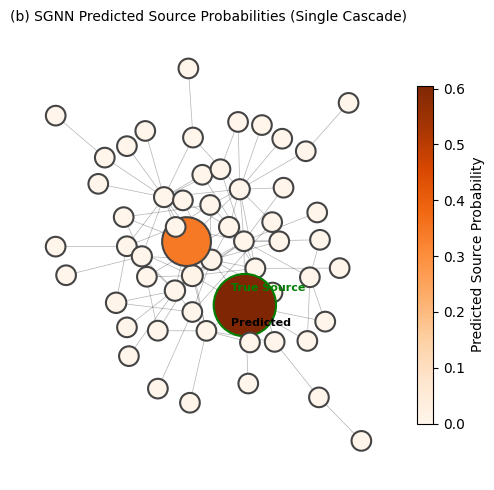

In [ ]:
probs, true_source, cascade = get_large_cascade_probs(model, G, device)
pred_source = int(np.argmax(probs))
plot_source_prob_heatmap_clean(G, probs, true_source, pred_source, cascade)


In [ ]:
import pandas as pd

# Save the edge list of the full graph
edge_df = pd.DataFrame(list(G.edges()), columns=["source", "target"])
edge_df.to_csv("graph_edges.csv", index=False)

# Save node probabilities
probs_df = pd.DataFrame({
    "node_id": list(range(len(probs))),
    "prob": probs
})
probs_df.to_csv("node_probs.csv", index=False)

# Save infection status (who was infected and when)
infection_time = {n: -1 for n in G.nodes()}
for t, nodes in enumerate(cascade):
    for n in nodes:
        if infection_time[n] == -1:
            infection_time[n] = t

infection_df = pd.DataFrame({
    "node_id": list(infection_time.keys()),
    "infection_time": list(infection_time.values())
})
infection_df.to_csv("infection_times.csv", index=False)

# Save source info
with open("source_info.txt", "w") as f:
    f.write(f"true_source,{true_source}\n")
    f.write(f"pred_source,{pred_source}\n")


In [ ]:
import pandas as pd

# Save edge list
nx_G = nx.Graph()
nx_G.add_edges_from(G.edges())
edge_df = nx.to_pandas_edgelist(nx_G)
edge_df.to_csv("graph_edges.csv", index=False)

# Save predicted probs
probs_df = pd.DataFrame({'node_id': np.arange(len(probs)), 'prob': probs})
probs_df.to_csv("node_probs.csv", index=False)

# Save source info
with open("source_info.txt", "w") as f:
    f.write(f"true_source,{true_source}\n")
    f.write(f"pred_source,{pred_source}\n")

In [45]:
import networkx as nx

def rumor_center_rank(G, infected_nodes):
    ecc_dict = {}
    for node in G.nodes():
        try:
            dists = [nx.shortest_path_length(G, node, t) for t in infected_nodes if nx.has_path(G, node, t)]
            ecc = max(dists) if dists else float('inf')
            ecc_dict[node] = ecc
        except nx.NetworkXNoPath:
            ecc_dict[node] = float('inf')
    sorted_nodes = sorted(ecc_dict, key=lambda n: ecc_dict[n])
    return sorted_nodes  # ranked list from best to worst


In [46]:
def top_k_accuracy_rumor_center(G, k_values=[1, 3, 5, 10, 20, 50, 100], num_samples=1000, mask_rate=0.2):
    results = {k: 0 for k in k_values}

    for _ in range(num_samples):
        source = random.choice(list(G.nodes()))
        cascade = simulate_ic(G, [source])
        infected_nodes = set().union(*cascade)

        # Apply infection masking
        if mask_rate > 0:
            infected_nodes = set(n for n in infected_nodes if random.random() > mask_rate)

        ranked_nodes = rumor_center_rank(G, infected_nodes)

        for k in k_values:
            if source in ranked_nodes[:k]:
                results[k] += 1

    for k in results:
        results[k] /= num_samples

    return results

In [47]:
def plot_topk_error_sgnn_vs_rumor_center(sgnn_results, rumor_results):
    ks = sorted(sgnn_results.keys())
    sgnn_error = [1 - sgnn_results[k] for k in ks]
    rumor_error = [1 - rumor_results[k] for k in ks]

    plt.figure(figsize=(5, 4))
    plt.plot(ks, sgnn_error, marker='o', label='SGNN', linewidth=2)
    plt.plot(ks, rumor_error, marker='s', linestyle='--', label='Rumor Center', linewidth=2)
    plt.xticks(ks)
    plt.ylim(0, 0.4)
    plt.xlabel("k")
    plt.ylabel("Top‑k Error")
    plt.title("Top‑k Error of SGNN vs Rumor Center")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [48]:
sgnn_results = res_top_k
rumor_results = top_k_accuracy_rumor_center(G, k_values=[1, 3, 5, 10, 20, 50, 100], num_samples=1000)

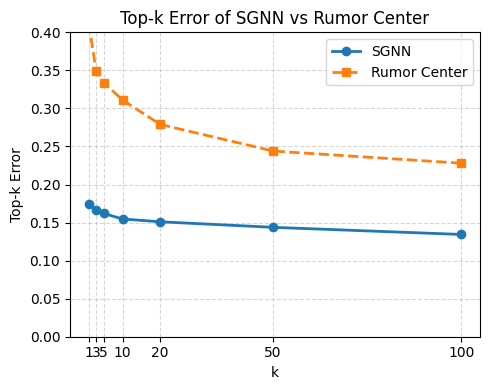

In [49]:
plot_topk_error_sgnn_vs_rumor_center(sgnn_results, rumor_results)

In [50]:
rumor_results

{1: 0.588, 3: 0.651, 5: 0.666, 10: 0.689, 20: 0.721, 50: 0.756, 100: 0.772}

In [51]:
comparison_dict = {
    k: {
        "SGNN": sgnn_results[k],
        "RumorCenter": rumor_results[k]
    }
    for k in [1, 3, 5, 10, 20, 50, 100]
}

In [52]:
comparison_dict

{1: {'SGNN': 0.8255208333333334, 'RumorCenter': 0.588},
 3: {'SGNN': 0.8333333333333334, 'RumorCenter': 0.651},
 5: {'SGNN': 0.8380208333333333, 'RumorCenter': 0.666},
 10: {'SGNN': 0.8453125, 'RumorCenter': 0.689},
 20: {'SGNN': 0.8489583333333334, 'RumorCenter': 0.721},
 50: {'SGNN': 0.85625, 'RumorCenter': 0.756},
 100: {'SGNN': 0.865625, 'RumorCenter': 0.772}}